# FIFA 21 IRONHACK COMPETITION

You will use the fifa21_trainning.csv dataset provided to predict the position ('OVA') of each player. The competition will take place from monday morning to tuesday. 
<br><br>
Your model will be saved in a pickle file.
<br><br>
The ranking of the competitors will be calculated according to the highest Mean Average Error (MAE), rounded to 2 decimals.
<br><br>
Ties will be broken using, respectively: R2 Score (rounded to 2 decimals), Root Mean Squared Error (rounded to 2 decimals), time to run the code (using timeit)
<br>


## DELIVERABLES:

Your group should deliver a `group Jupyter notebook` with all the preprocessing functions alongside with the model.

Everything must be delivered until 12am on Tuesday. 
<br><br>
Be prepared to share your work on Tuesday morning, the best scores will have the opportunity to show their notebook and go through their pipeline (~10 min).
<br><br>

To deliver:
* A notebook with your work and model (group_number.ipynb);
* Pickle file with the model (group_number.pkl). 
<br><br>

The instructor will use your `group Jupyter notebook` to load a new dataset and use your functions and
your model to make a prediction in unseen data.



# Your code from here on:

OBS.: Do everything you need above the cell below, then select your best model and return it as an object so it can be saved as a pickle file.

In [1]:
# Usual modules
import pandas as pd
import numpy as np

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#progress bar
from tqdm.notebook import tqdm 

Installation commands
* **Pycountry-convert** (only available via pip, make a safe copy of your environment first, e.g. with `conda create --name ironhack_safe --clone ironhack` )
```bash
pip install pycountry-convert
```

# 0. Data load 

In [2]:
data = pd.read_csv("../fifa21_trainning.csv")

# 1. Missing values exploration

In [3]:
float_nulls = data.select_dtypes(['int64','float64'])

In [4]:
nulls = pd.DataFrame(float_nulls.isna().sum()/len(float_nulls))
nulls = nulls.reset_index()
nulls.columns = ['column_name', 'Percentage Null Values']
nulls[nulls['Percentage Null Values']>0].sort_values(by='Percentage Null Values', ascending = False)

,column_name,Percentage Null Values
34,Composure,0.024015
9,Volleys,0.003212
12,Curve,0.003212
19,Agility,0.003212
21,Balance,0.003212
24,Jumping,0.003212
32,Vision,0.003212
38,Sliding Tackle,0.003212
30,Interceptions,0.000511
31,Positioning,0.000511


# 2. Preprocessing functions

## Defining functions for each preprocessing step

In [5]:
# Function which transforms height column to total inches (as float)
def parse_ht(ht):
    ht_ = ht.split("\'")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_

# Function which transforms the value column to total Euros (as float)
def parse_v(v):
    vmk_ = v[-1]
    v_ = v[:-1]
    if vmk_ == "M":
        v_ = float(v_)*100000
    elif vmk_ == "K":
        v_ = float(v_) * 1000
    else:
        v_ = np.nan
    return v_

# Function wich transforms the hits column to total hits (as float)
def parse_hits(h):
    k_ = h[-1]
    if k_ == "K":
        v_ = h[:-1]
        v_ = float(v_)*1000
    else:
        v_ = h
    return v_

# Two functions which extract from any rating column the value left (rt_l)
# and the value right (rt_r) of the '+'
def parse_rt_l(rt):
    rt_ = rt.split("+")
    rt_l = float(rt_[0])
    return rt_l

def parse_rt_r(rt):
    rt_ = rt.split("+")
    rt_r = float(rt_[1])
    return rt_r

# Generating continent feature from country using library pycountry
def continent(c_name):
    if c_name in ['Bosnia Herzegovina', 'Republic of Ireland', 'Kosovo']:
         return 'Europe'
    elif c_name in ['Korea DPR','Chinese Taipei']:
        return 'Asia'
    elif c_name in ['Trinidad &amp; Tobago']:
        return 'South America'
    elif c_name in ['Antigua &amp; Barbuda']:
        return 'North America'
    elif c_name in ['São Tomé &amp; Príncipe']:
        return 'Africa'
    else:
        try:
            country_alpha2 = pc.country_name_to_country_alpha2(c_name)
            country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
            country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
            return country_continent_name
        except:
            try:
                country_names = [x.name.lower() for x in pycountry.countries]    
                matching_countries = difflib.get_close_matches(c_name, country_names)
                confidence = difflib.SequenceMatcher(None, matching_countries[0], c_name).ratio()
                country_alpha2 = pc.country_name_to_country_alpha2(matching_countries[0].title())
                country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
                country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
                return country_continent_name
            except:
                #Europe is the most common
                return 'Europe'

# make a function that takes in the dataset and applies all 
# transformations returning the transformed X and y
# The "Big mama"
def clean_dataset(dataset):
    ###Your code here###
    ###forbidden to drop outliers###
    import pycountry_convert as pc
    import difflib
    from sklearn.preprocessing import StandardScaler
    from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
    
    fifa21_trainning = dataset
    
    #fifa21_trainning = pd.read_csv("fifa21_trainning.csv")

    impute_mean_list =  ['Value','Composure','Volleys','Curve','Agility','Balance', 
                         'Jumping','Vision','Sliding Tackle','Interceptions',
                         'Positioning','Wage','Release Clause','Joined']
    
    money_list = ["Value","Wage","Release Clause"]
    
    star_list = ['W/F','SM','IR']
    
    ratings_list = ['LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB',
                    'GK','RW','LAM','CAM','RAM','LM','LCM','CM','RCM',
                    'RM','LWB','LS','ST','RS','LW','LF','CF','RF']
    
    low_med_high = ['A/W','D/W']
    
    low_med_high_dict = {'Low':0,'Medium':1,'High':2,np.NaN:1}

    fifa21_trainning["Height"] = fifa21_trainning["Height"].apply(lambda x: parse_ht(x))
    fifa21_trainning["Weight"] = fifa21_trainning["Weight"].str.replace('lbs', '')
    fifa21_trainning["Weight"] = fifa21_trainning["Weight"].astype('int64')

    fifa21_trainning['Joined'] = pd.to_datetime(fifa21_trainning['Joined'])
    fifa21_trainning['Joined'] = fifa21_trainning['Joined'].apply(lambda x: 2020 - x.year)

    for i in ratings_list:
        fifa21_trainning[i+str("1")] = fifa21_trainning[i].apply(lambda x: parse_rt_l(x))
        fifa21_trainning[i] = fifa21_trainning[i].apply(lambda x: parse_rt_r(x))

    for i in money_list:
        fifa21_trainning[i] = fifa21_trainning[i].str.replace('€', '')
        fifa21_trainning[i] = fifa21_trainning[i].apply(lambda x: parse_v(x))

    for i in impute_mean_list:
        fifa21_trainning[i] = fifa21_trainning[i].fillna(fifa21_trainning[i].mean())

    for i in money_list:
        fifa21_trainning[i] = fifa21_trainning[i].astype('int64')

    for i in star_list:
        fifa21_trainning[i] = fifa21_trainning[i].str[0].astype('int64')

    for i in low_med_high:    
        fifa21_trainning[i] = fifa21_trainning[i].map(low_med_high_dict)

    fifa21_trainning['A/W'] = fifa21_trainning['A/W'].fillna(1)
    fifa21_trainning['D/W'] = fifa21_trainning['D/W'].fillna(1)
    fifa21_trainning["Hits"] = fifa21_trainning["Hits"].apply(lambda x: parse_hits(x))
    fifa21_trainning['Hits'] = fifa21_trainning['Hits'].astype('int64')
    fifa21_trainning["Nationality"] = fifa21_trainning["Nationality"].apply(lambda x: continent(x))

    list_to_dummify = ['foot','Nationality','BP']
    to_dummify = fifa21_trainning[list_to_dummify]
    
    fifa21_trainning.drop(columns=['Unnamed: 0','Club','Position',
                                   'Team & Contract','Loan Date End'], axis = 1, inplace = True)
    y = fifa21_trainning['OVA']
    fifa21_trainning.drop(columns=['OVA'], inplace = True)
    fifa21_trainning['OVA'] = y

    return fifa21_trainning

In [6]:
data.head()

,Unnamed: 0,ID,Name,Age,Nationality,Club,BP,Position,Team & Contract,Height,...,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,1954,184383,A. Pasche,26,Switzerland,FC Lausanne-Sport,CM,CM CDM,FC Lausanne-Sport 2015 ~ 2020,"5'9""",...,59+1,59+1,59+1,58+1,54+1,54+1,54+1,58+1,15+1,64
1,2225,188044,Alan Carvalho,30,China PR,Beijing Sinobo Guoan FC,ST,ST LW LM,"Beijing Sinobo Guoan FC Dec 31, 2020 On Loan","6'0""",...,53+2,53+2,57+2,53+2,48+2,48+2,48+2,53+2,18+2,77
2,1959,184431,S. Giovinco,33,Italy,Al Hilal,CAM,CAM CF,Al Hilal 2019 ~ 2022,"5'4""",...,56+2,56+2,59+2,53+2,41+2,41+2,41+2,53+2,12+2,80
3,9815,233796,J. Evans,22,Wales,Swansea City,CDM,CDM CM,Swansea City 2016 ~ 2021,"5'10""",...,58+2,58+2,56+2,57+2,58+2,58+2,58+2,57+2,14+2,59
4,10074,234799,Y. Demoncy,23,France,US Orléans Loiret Football,CDM,CDM CM,US Orléans Loiret Football 2018 ~ 2021,"5'11""",...,64+2,64+2,64+2,63+2,61+2,61+2,61+2,63+2,15+2,65


In [7]:
data['OVA'].head()

0    64
1    77
2    80
3    59
4    65
Name: OVA, dtype: int64

# 3. Function to train the linear model

In [8]:
# Function to train a model with a given X and y.
def train_model(X, y):
    """
    Params:
        X: a set of feature columns
        y: a target column
    Returns: A trained LinearRegression() model
    """
    model = LinearRegression()
    model.fit(X, y)
    return model

# 4. Splitting data

In [9]:
data_clean = clean_dataset(data)

# Seperating features and label
y = data_clean['OVA']
X = data_clean.drop(columns=['OVA','ID','Name'], axis = 1)

X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(np.object)

# Numericals

## Correlation matrix

Age       0.519422
Height    0.028974
Weight    0.150692
Growth    0.596555
Joined    0.213253
            ...   
LW1       0.424891
LF1       0.452413
CF1       0.452413
RF1       0.452413
OVA       1.000000
Name: OVA, Length: 118, dtype: float64


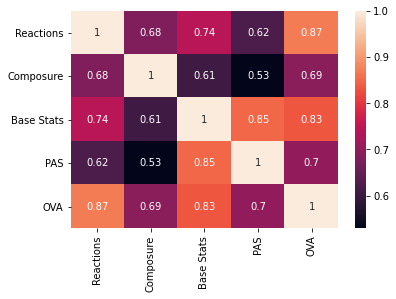

In [10]:
import seaborn as sns

df = pd.concat([X_num,y], axis = 1)
corr_mat = abs(df.corr())
print(corr_mat.iloc[:,-1])
dfc = corr_mat.iloc[:,-1]
dfc[dfc > 0.65]

corr_new = df[['Reactions','Composure','Base Stats','PAS','OVA']].corr()
sns.heatmap(corr_new, annot = True);

According to the correlation matrix, the best numerical features to use are:
    
* Reactions
* Composure
* Base Stats

In [11]:
X_num = X_num[['Reactions','Composure','Base Stats']]

# Categoricals

In [12]:
X_cat.head()

,Nationality,BP,foot,Contract
0,Europe,CM,Right,2015 ~ 2020
1,Europe,ST,Right,"Dec 31, 2020 On Loan"
2,Europe,CAM,Right,2019 ~ 2022
3,Europe,CDM,Right,2016 ~ 2021
4,Europe,CDM,Right,2018 ~ 2021


Contract column, doesn't make any sense to predict 'OVA'. Therefore, we can drop it. 

In [13]:
X_cat.drop(columns='Contract', axis = 1, inplace = True)

/home/flo/anaconda3/envs/ironhack/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Getting the levels each categorical feature.

Column:  Nationality


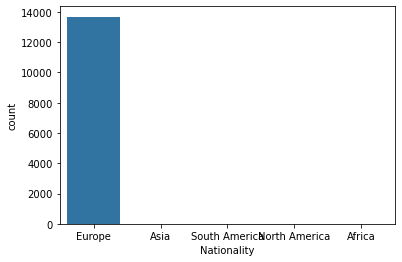

Column:  BP


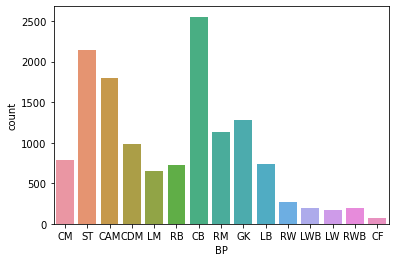

Column:  foot


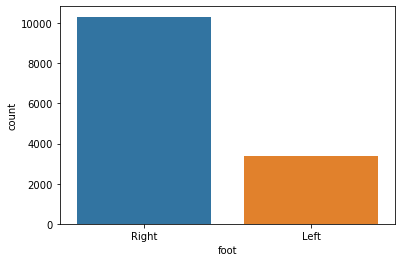

In [14]:
for c in X_cat.columns:
    print("Column: ", c)
    print("========================")
    sns.countplot(x=c, data=X_cat)
    plt.show()
    print("========================")
    

Clearly we can see that in the dataset all the players are from `Europe`. Therefore, the model will not be able to predict any player not from `Europe` as there are no samples in the dataset. Then we can't use `Nationality`; it must be dropped.

In addition, the for remaining variables: `BP` and `foot` the all the possible values are not evenly sampled. Therefore, we can expect that the model will predict better the players for which the corresponding values in those features are more represented. We're not going to deal with this problem yet.

In [15]:
X_cat.drop(columns='Nationality', axis = 1, inplace = True)
X_cat.head()

/home/flo/anaconda3/envs/ironhack/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,BP,foot
0,CM,Right
1,ST,Right
2,CAM,Right
3,CDM,Right
4,CDM,Right


## Dealing with categoricals

The variable `foot` is boolean, therefore we will not dummify it. We will make it boolean.

In [16]:
X_cat['foot'] = np.where(X_cat['foot'] == 'Left',1,0)
X_cat['foot'].head()

<ipython-input-16-fb4f0a95a0e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat['foot'] = np.where(X_cat['foot'] == 'Left',1,0)


0    0
1    0
2    0
3    0
4    0
Name: foot, dtype: int64

In [17]:
import pickle

X_cat_dum = pd.get_dummies(X_cat['BP'], drop_first=True)
bp_list = list(X_cat_dum.columns)

file_name = "bp_levels.pkl"

open_file = open(file_name, "wb")
pickle.dump(bp_list, open_file)
open_file.close()

X_cat_dum = pd.concat([X_cat_dum,X_cat['foot']], axis = 1)
X_cat_dum.head()

,CB,CDM,CF,CM,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST,foot
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Merging numerical and categoricals back

In [18]:
from sklearn.model_selection import train_test_split

y = data_clean['OVA']
X = pd.concat([X_num,X_cat_dum], axis = 1)

display(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train)
X_test_scaled  = standard.transform(X_test)


,Reactions,Composure,Base Stats,CB,CDM,CF,CM,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST,foot
0,66,54.0,357,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,75,70.0,412,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,78,82.0,404,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,55,48.0,329,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,62,58.0,360,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Train-test split

In [19]:
from joblib import dump
from joblib import load

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train)
X_test_scaled  = standard.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns = X_test.columns)

X_train_scaled.head()

# Saving the scaler
dump(standard, 'standard_scaler.joblib')

['standard_scaler.joblib']

# Creating and storing the model

In [20]:
model = train_model(X_train_scaled, y_train)
with open('linear_model.pkl', 'wb') as file: 
    pickle.dump(model, file)

# Function to plot results

In [32]:
def plot_errors(y, y_pred):
    
    X_plot = np.linspace(0, 100, 1000)
    Y_plot = X_plot

    fig, ax = plt.subplots()
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(7, 7)})
    plt.ylabel("Predicted 'OVA'")
    plt.title("Test set: Predictions against real values")
    sns.regplot(x=y, y=y_pred, fit_reg=False, ax=ax,scatter_kws={"color": "green", "s":1})
    plt.plot(X_plot, Y_plot, color='r',linewidth=4.)
    plt.show()
    
    sns.displot(y-y_pred, kde=True)
    plt.title("Train set: Distribution of residuals")
    plt.show()

In [22]:
def transform_data(X):
    
    # Fixing categoricals
    X['foot'] = np.where(X['foot'] == 'Left',
                         1,
                         0)
    
    # Restoring levels of 'BP'    
    open_file = open(file_name, "rb")
    bp_list = pickle.load(open_file)
    open_file.close()
    
    for col in bp_list:
        X[col] = np.where(X['BP'] == col, 1,0)
    
    X.drop(columns='BP', axis = 1, inplace = True)
    
    # Merging columns
    X = pd.concat([X[['Reactions','Composure','Base Stats']],
                   X[bp_list],
                   X['foot']],
                  axis = 1)
    
    # Scaling column values
    # First loading the scaler
    scaler = load('standard_scaler.joblib')
    
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
    
    return X_scaled

# Function for model validation

In [23]:
def validation(model, validation_data):
    
    data = clean_dataset(validation_data)
    
    y = data['OVA']
    X = data.drop(columns='OVA', axis = 1)

    X_scaled = transform_data(X)
    
    y_pred = model.predict(X_scaled)
    
    plot_errors(y, y_pred)
    
    ###Check if your prediction needs rounding here###    
    
    mae = round(mean_absolute_error(y, y_pred), 2)
    mse = round(mean_squared_error(y,y_pred),2)
    rmse = round(np.sqrt(mse),2)
    mape = round(np.mean((y - y_pred)/y)*100,2)
    r2 = round(r2_score(y, y_pred), 2)
    
    print('MAE:', mae)
    print('MSE:', mse)
    print('MAPE: {} %'.format(mape))
    print('RMSE:', rmse)
    print('R2 Score:', r2)
    
    return mae, mse, rmse, mape, r2

In [25]:
validation_data = pd.read_csv('fifa21_validation.csv') 
validation_data['OVA'].head()

0    59
1    65
2    62
3    68
4    76
Name: OVA, dtype: int64

# Main program

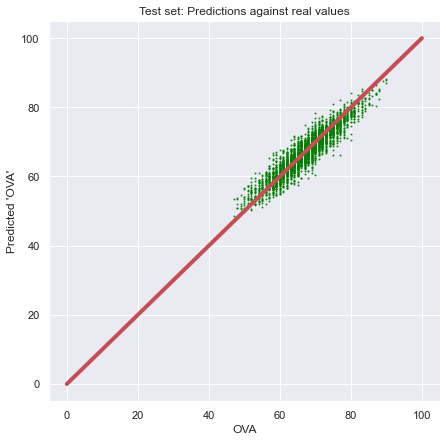

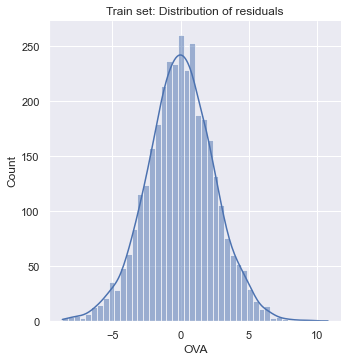

MAE: 1.95
MSE: 6.22
MAPE: -0.15 %
RMSE: 2.49
R2 Score: 0.87
Time to process: 0.00040477900074620266  seconds


In [34]:
import timeit

# load validation data
# you won't have access to 'fifa21_validation.csv'
# create your own validation dataset with your test data
validation_data = pd.read_csv('fifa21_validation.csv') 

#display(validation_data.head())

# load model
## replace 'your_name' with your actual name
with open('linear_model.pkl', 'rb') as file: 
    model = pickle.load(file)

tic = timeit.timeit()     
# print metrics
mae, mse, rmse, mape, r2 = validation(model, validation_data)

toc = timeit.timeit()
time = toc-tic

print('Time to process:', time, ' seconds')

* **MAE**: Mean average error, average of the absolute value of every error, meaning
$$\frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|$$

Easy to understand, because it's in units of `y`, but doesn't penalize big errors. Therefore not sensitive for big outliers

* **MSE**: Mean squared error, Average of the squared errors, meaning
$$\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

Penalizes big errors (that's a benefit), but not in units of `y` (not that intuitive)

* **MAPE**: Mean absolute percentage error, meaning
$$\frac{1}{n} \sum_{i=1}^n |\frac{y_i - \hat{y}_i}{\hat{y}_i}|$$

* **RMSE**: Root mean squared error. MSE but square rooted, meaning 
$$\sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$$

Most common, since it can be interpreted in units of `y` **and** penalizes outliers

* **R2 score** : How much variance does my model explain? Basically compares the squared errors of my model with a model that bluntly predicts only the mean of my `y` values. Mathematically

$$R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y}_i)^2}$$